# Import required packages

In [10]:
%reload_ext autoreload
%autoreload 2

# system libraries
import os
import sys
sys.path.append("..")

# package for image processing and display
from PIL import Image

# helper functions defined in the utils module
from utils import *

# Data Exploration & Preprocessing

Visualize orginal images;
detect black corners and crop the images in such cases
resize the images to 400x400

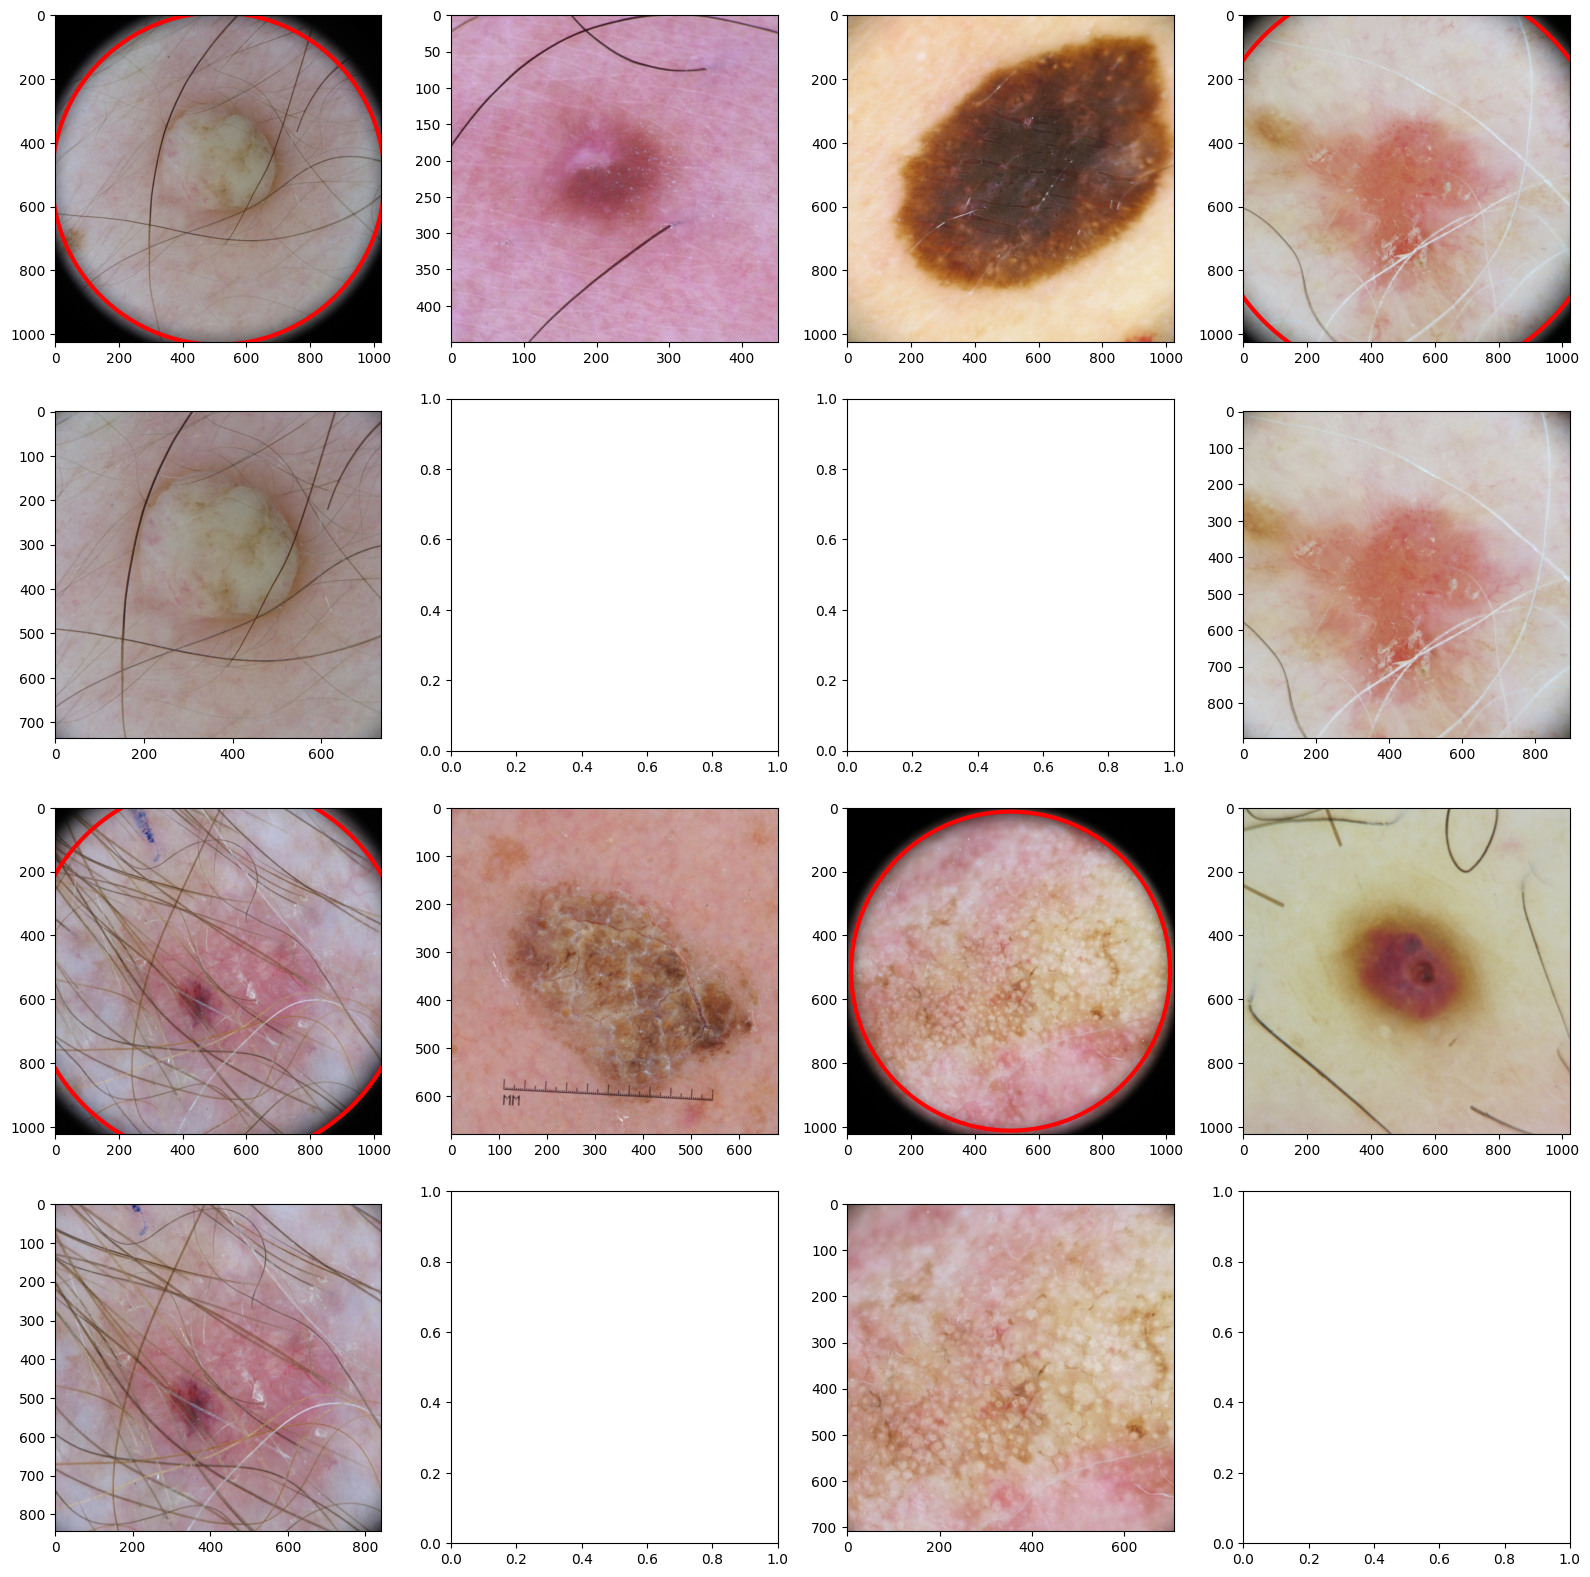

In [12]:
n_samples = 8
image_samples= get_ground_truth_data(n_samples)

num_cols = 4  # Number of columns in the grid
num_rows = (n_samples*2 - 1) // num_cols + 1  # Number of rows in the grid

fig, axes = plt.subplots(num_rows, num_cols, figsize=(4*num_cols, 4*num_rows))

for i in range(n_samples):
    sample=image_samples.loc[i]
    
    # step 1 - Load the image
    image_file_name=f"{os.path.sep.join(['../raw_data', sample.Cat, sample.image])}.jpg"
    image = Image.open(image_file_name)
    # Square_Crop
    image = square_image(image)
    # Detect corner edges
    radius = detect_black_coners(image)
    ax = axes[(i // num_cols)*2, i % num_cols] if num_rows > 1 else axes[i % num_cols]
    display_image_with_circle(image, radius, ax)
    if radius> 0:
        image_cropped=remove_black_corners(image, radius=radius)
        ax = axes[(i // num_cols)*2+1, i % num_cols] if num_rows > 1 else axes[i % num_cols]
        display_image(image_cropped, ax)

plt.tight_layout()
plt.show()

# Feature Engineering

Raw data set is not balanced. there are too many NV data
 - Negative: (NV-12878, BKL-2624, DF-239, VASC-253)
 - Positive: (MEL-4522, BCC-3323, AK-867, SCC-628)

Data balancing strategy:
 - NV:reduce to 4500
 - BKL/DF/VASC - no change needed for the best recall - what about accuracy?!
 - MEL/BCC - well balanced, no change
 - AK/SCC - x5 by roating and flipping

## Export downsized groud truth file

In [ ]:
data = load_raw_data()
data_NV_drop =  data[data.Cat=='NV'].sample(8000, random_state=42)

data_downsized = data.drop(data_NV_drop.index)
data_downsized.to_csv('processed_data/ISIC_2019_Training_GroundTruth_Processed.csv', index=False)

## Export preprocessed images

In [ ]:
############################## Expport preprocessed images.##############################
images = data_downsized
for i in range(images.shape[0]):
    item=images.iloc[i]
    image_file_name=f"{os.path.sep.join(['../raw_data', item.Cat, item.image])}.jpg"
    image_file_name_output=f"{os.path.sep.join(['../processed_data', item.Cat, item.image])}.jpg"
    
    # Load the image
    image = Image.open(image_file_name)
    # Square_Crop
    image = square_image(image)

    # Detect and remove corner edges
    radius = detect_black_coners(image)
    if radius> 0:
        image=remove_black_corners(image, radius=radius)
    # resize image
    image = image.resize((400,400),resample=Image.BILINEAR)
    
    # export image file
    image.save(image_file_name_output)
    print(f'file {image_file_name_output} saved...')

## Feature Argumentation 

- AK: 867, add 867*4 images by rotating and flipping
- SCC: 628, add 628*4 images by rotating and flipping

### Load processed images

In [ ]:
file_name = 'processed_data/ISIC_2019_Training_GroundTruth_Processed.csv'
data_processed = pd.read_csv(file_name)

### Generate images

In [ ]:
images = data_processed.loc[data_processed.Cat=='SCC'] #need to run this code again for 'AK'
for i in range(images.shape[0]):
    item=images.iloc[i]
    image_file_name=f"{os.path.sep.join(['../processed_data', item.Cat, item.image])}.jpg"
   # Load the image
    image = Image.open(image_file_name)
    # export image file
    for deg in range(90, 271, 90):
        image_file_name_out=f"{os.path.sep.join(['../processed_data', item.Cat+'_', item.image+'_'+str(deg)])}.jpg"
        rotated_image = image.rotate(deg)
        rotated_image.save(image_file_name_out)
        print(f'file {image_file_name_out} saved...')
    flipped_image = image.transpose(Image.FLIP_LEFT_RIGHT)
    image_file_name_out=f"{os.path.sep.join(['../processed_data', item.Cat+'_', item.image+'_flipped'])}.jpg"
    flipped_image.save(image_file_name_out)
    print(f'file {image_file_name_out} saved...')

### Update the ground truth csv file

In [ ]:
SCC = data_processed.loc[data_processed.Cat=='SCC']
SCC_90 = SCC.copy()
SCC_90.image=SCC.image+'_90'
SCC_90
SCC_180 = SCC.copy()
SCC_180.image=SCC.image+'_180'
SCC_180
SCC_270 = SCC.copy()
SCC_270.image=SCC.image+'_270'
SCC_270
SCC_flipped = SCC.copy()
SCC_flipped.image=SCC.image+'_flipped'
SCC_flipped

AK = data_processed.loc[data_processed.Cat=='AK']
AK_90 = AK.copy()
AK_90.image=AK.image+'_90'
AK_90
AK_180 = AK.copy()
AK_180.image=AK.image+'_180'
AK_180
AK_270 = AK.copy()
AK_270.image=AK.image+'_270'
AK_270
AK_flipped = AK.copy()
AK_flipped.image=AK.image+'_flipped'
AK_flipped
pd = pd.concat([data_processed, SCC_90, SCC_180, SCC_270, SCC_270, SCC_flipped, AK_90, AK_180, AK_270, AK_270, AK_flipped])

file_name = 'processed_data/ISIC_2019_Training_GroundTruth_Processed_Balanced.csv'
pd.to_csv(file_name, index=False)

## Check the results

In [14]:
load_processed_balanced_data()

,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK,Cat,y
0,ISIC_0000001,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NV,0
1,ISIC_0000002,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MEL,1
2,ISIC_0000003,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NV,0
3,ISIC_0000004,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MEL,1
4,ISIC_0000007,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NV,0
...,...,...,...,...,...,...,...,...,...,...,...,...
24801,ISIC_0073153_flipped,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,AK,1
24802,ISIC_0073157_flipped,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,AK,1
24803,ISIC_0073198_flipped,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,AK,1
24804,ISIC_0073214_flipped,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,AK,1
